In [1]:
#!rm -r /home/jovyan/.local/share/jupyter/kernels/nilmtk
!mamba install tensorflow-gpu==2.10 -y -q
# !mamba install tensorflow-gpu==2.11.0 -y -q
!pip uninstall -y -q nilmtk nilm_metadata
#!pip install -q pandas networkx tables scikit-learn hmmlearn pyyaml matplotlib==3.1.3 xgboost pyts
# Trick to install NILM regardless of its dependencies
#!pip install --no-cache -U git+https://github.com/nilmtk/nilm_metadata.git
#!pip install --no-cache -U git+https://github.com/nilmtk/nilmtk.git@0.4.3
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilm_metadata@master

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

By downloading and using the cuDNN conda packages, you accept the terms and conditions of the NVIDIA cuDNN EULA -
  https://docs.nvidia.com/deeplearning/cudnn/sla/index.html

done
  Cloning https://github.com/nilmtk/nilmtk (to revision master) to /tmp/pip-req-build-86zl6wcq
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk /tmp/pip-req-build-86zl6wcq
  Resolved https://github.com/nilmtk/nilmtk to commit b2c514479cef478cab872cb635056da08d5352a1
  Preparing metadata (setup.py) ... done
  Created wheel for nilmtk: filename=nilmtk-0.4.0.dev1+git.b2c5144-py3-none-any.whl size=279177 sha256=751d23652d8e145eb68f25de847eef608f5958d4aca7a5657f31ffb4994d05

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory
import pickle
from pprint import pprint

#from nilmtk import DataSet
import multiprocessing as mp

from typing import Dict

!pip install -q scikit-learn-intelex
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network
!pip install xgboost -q
import xgboost as xgb

import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
#import graphviz
import keras
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
#from ann_visualizer.visualize import ann_viz
from matplotlib import pyplot as plt 
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
# GPU goes brrrrrrrrrrrrrrrrrrrr
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_bfloat16') # bfloat16

!pip3 install tqdm -q
from tqdm.notebook import tqdm
import NUK

# import garbage collector
import gc
import time


physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print(physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU found, model will train on CPU.")


2023-12-12 12:12:13.006790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100 80GB PCIe MIG 3g.40gb, compute capability 8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocessing

# Models

In [3]:
# Parameters

epochs =1200
window_size = 2688
batch_size = 128
NmDevices = 64
# table_of_options = [1,2,3,4]
k = 0.125
# Define a learning rate scheduler function
# def scheduler(epoch, lr):
#     return lr
#     if epoch == 0 or epoch == 1:
#         return lr
#     if epoch == 35:
#         return lr *0.5
#     else:
#         return lr

RANDOM_SEED = 42
test_size = 0.2
lambda_l2=0
function = "GRU"

In [5]:
# Read data
# data= pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl")
data= pd.read_pickle("../Energy_graph_data/X_Y_wsize2688_numW_100000_upper32_gap3600_numD64_ideal.pkl")

labels = pd.read_pickle("../../Energy_graph/data/labels_new.pkl")


NmDevices = len(labels)

X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])



# T/F to 1/0
y = y.astype(int)



# min-max normalization Xmin=0 
def normalize(X):
    max_value = 0

    for x in X:
        v = np.max(x)
        if v > max_value:
            max_value = v

    if max_value == 0:
        return X
    return X / max_value

    




In [55]:
len(labels)

64

## InceptionTime

### InceptionTime class

In [7]:
# CHECK INCEPTION TIME IMPLEMENTATION 


class_weighs_pre = NUK.class_weights_tool(y)

class Classifier_INCEPTION:

    def __init__(self, output_directory, input_shape, nb_classes, iteration, verbose=False, build=True, batch_size=64,
                 nb_filters=32, use_residual=True, use_bottleneck=True, depth=6, kernel_size=41, nb_epochs=1500, lr=0.001):

        self.output_directory = output_directory

        self.nb_filters = nb_filters
        self.use_residual = use_residual
        self.use_bottleneck = use_bottleneck
        self.depth = depth
        self.kernel_size = kernel_size - 1
        self.callbacks = None
        self.batch_size = batch_size
        self.bottleneck_size = 32
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.iteration = iteration

        if build == True:
            self.model = self.build_model(input_shape, nb_classes)
            self.verbose = verbose
            self.model.save_weights(self.output_directory + 'model_init.hdf5')

    def _inception_module(self, input_tensor, stride=1, activation='linear'):

        if self.use_bottleneck and int(input_tensor.shape[-1]) > 1:
            input_inception = keras.layers.Conv1D(filters=self.bottleneck_size, kernel_size=1,
                                                  padding='same', activation=activation, use_bias=False)(input_tensor)
        else:
            input_inception = input_tensor

        
        kernel_size_s = [self.kernel_size // (2 ** i) for i in range(3)]

        conv_list = []

        for i in range(len(kernel_size_s)):
            conv_list.append(keras.layers.Conv1D(filters=self.nb_filters, kernel_size=kernel_size_s[i],
                                                 strides=stride, padding='same', activation=activation, use_bias=False)(
                input_inception))

        max_pool_1 = keras.layers.MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)

        conv_6 = keras.layers.Conv1D(filters=self.nb_filters, kernel_size=1,
                                     padding='same', activation=activation, use_bias=False)(max_pool_1)

        conv_list.append(conv_6)

        x = keras.layers.Concatenate(axis=2)(conv_list)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activation='relu')(x)
        return x

    def _shortcut_layer(self, input_tensor, out_tensor):
        shortcut_y = keras.layers.Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1,
                                         padding='same', use_bias=False)(input_tensor)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        x = keras.layers.Add()([shortcut_y, out_tensor])
        x = keras.layers.Activation('relu')(x)
        return x

    def build_model(self, input_shape, nb_classes):
        input_layer = keras.layers.Input(input_shape)

        x = input_layer
        input_res = input_layer

        for d in range(self.depth):

            x = self._inception_module(x)

            if self.use_residual and d % 3 == 2:
                x = self._shortcut_layer(input_res, x)
                input_res = x

        gap_layer = keras.layers.GlobalAveragePooling1D()(x)

        output_layer = keras.layers.Dense(nb_classes, activation='sigmoid')(gap_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)
        # cross entropy loss ?
        model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=self.lr),
                      metrics=['accuracy', NUK.F1Score, NUK.WeightedF1Score(class_weighs_pre)])

        # callbacks
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.25, patience=7, min_lr=0.0001)
        early_stopping = keras.callbacks.EarlyStopping(patience=9, restore_best_weights=True, monitor='loss')

        file_path = self.output_directory + f'best_model_{self.iteration}.hdf5'

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                           save_best_only=True)
        self.callbacks = [reduce_lr, model_checkpoint, early_stopping]

        return model

    def fit(self, x_train, y_train):
       

        if self.batch_size is None:
            mini_batch_size = int(min(x_train.shape[0] / 10, 16))
        else:
            mini_batch_size = self.batch_size

        self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=self.nb_epochs,
                                  verbose=self.verbose, callbacks=self.callbacks, validation_split=0.1)


        self.model.save(self.output_directory + f'last_model_{self.iteration}.hdf5')

        keras.backend.clear_session()

        return None

    def predict(self, x_test):
        model_path = self.output_directory + f'last_model_{self.iteration}.hdf5'
        model = keras.models.load_model(model_path, custom_objects={'F1Score': NUK.F1Score, "WeightedF1": NUK.WeightedF1Score(class_weighs_pre)})
        y_pred = model.predict(x_test, batch_size=self.batch_size)

        return y_pred


### Single model

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
evaluation_results = []
predictions = []
class_weights_all = NUK.class_weights_tool(y)
itr = 0
for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = normalize(X_train)
    X_test = normalize(X_test)
    print(batch_size, epochs)
    model = Classifier_INCEPTION(output_directory="./models/", input_shape=(window_size, 1), nb_classes=78, verbose=True, build=True, batch_size=batch_size, nb_epochs=epochs, lr=0.001, depth=6)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_tf = (y_pred > 0.5)

    predictions.append((y_pred_tf, y_test, y_pred))
    t = (y_pred_tf, y_test, y_pred)
    with open(f"./predictions/test_inception_pickle_{itr}.pkl", 'wb') as f:
        pickle.dump(t, f)

    itr += 1
    report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    print(report["weighted avg"])
    evaluation_results.append(report)
    gc.collect()
    tf.keras.backend.clear_session()

for i in range(len(evaluation_results)):
    if i == 0:
        df = pd.DataFrame(evaluation_results[i]).T
    else:
        df = df + pd.DataFrame(evaluation_results[i]).T


df = df / 5
import os
# check if directory exsits
if not os.path.exists(f"../../Energy_graph/data/results/{window_size}"):
    os.makedirs(f"../../Energy_graph/data/results/{window_size}")
if lambda_l2 == 0:
    df.to_csv(f"../../Energy_graph/data/results/{window_size}/Inception_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn.csv")
else:
    df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn_reg{lambda_l2}.csv")



    


### Ensemble

#### k-fold

In [ ]:
num_splits = 3
treshold = 0.3
kf = KFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_SEED)
evaluation_results = []
predictions = []
class_weights_all = NUK.class_weights_tool(y)
for fold,(train_index, test_index) in tqdm(enumerate(kf.split(X))):
    # print("Train indices:", train_index, "Test indices:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # normalization
    X_train = normalize(X_train)
    X_test = normalize(X_test)
    model_predictions = []

    print(batch_size, epochs)
    # train ensemble of 5 models
    for i in range(5):

        model = Classifier_INCEPTION(output_directory=f"./models/{fold}/", input_shape=(window_size, 1), nb_classes=78, verbose=True, build=True, batch_size=batch_size, nb_epochs=epochs, lr=0.001, depth=8, iteration=i)
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred = model.predict(X_test)
        model_predictions.append(y_pred)

    # average the predictions of the 5 models
    y_pred = np.mean(model_predictions, axis=0)
    y_pred_tf = (y_pred > treshold)

    predictions.append((y_pred_tf, y_test, y_pred))
    t = (y_pred_tf, y_test, y_pred)
    with open(f"./predictions/test_inception_pickle_{fold}.pkl", 'wb') as f:
        pickle.dump(t, f)

    report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    print(report["weighted avg"])
    
    evaluation_results.append(report)
    gc.collect()
    tf.keras.backend.clear_session()

for i in range(len(evaluation_results)):
    if i == 0:
        df = pd.DataFrame(evaluation_results[i]).T
    else:
        df = df + pd.DataFrame(evaluation_results[i]).T


df = df / num_splits
import os
# check if directory exsits
if not os.path.exists(f"../../Energy_graph/data/results/{window_size}"):
    os.makedirs(f"../../Energy_graph/data/results/{window_size}")
if lambda_l2 == 0:
    df.to_csv(f"../../Energy_graph/data/results/{window_size}/NNE_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn_3fold.csv")
else:
    df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn_reg{lambda_l2}.csv")



    


#### 80/20 split

In [15]:
# CHECK CODE HERE ############################################################################################################################################################################################################################

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train = normalize(X_train)
X_test = normalize(X_test)

evaluation_results = []
predictions = []
class_weights_all = NUK.class_weights_tool(y)
model_predictions = []

print(batch_size, epochs)
# train ensemble of 5 models
for i in range(5):

    model = Classifier_INCEPTION(output_directory=f"./models/performance/", input_shape=(window_size, 1), nb_classes=NmDevices, verbose=True, build=True, batch_size=batch_size, nb_epochs=epochs, lr=0.001, depth=10, iteration=i, kernel_size=128)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    model_predictions.append(y_pred)

# ensemble predictions
y_pred = np.mean(model_predictions, axis=0)

# thresholding
y_pred_tf = (y_pred > 0.3)

# save predictions for later analaysis
predictions.append((y_pred_tf, y_test, y_pred))
t = (y_pred_tf, y_test, y_pred)
with open(f"./predictions/test_inception_pickle_bfloat16_testing.pkl", 'wb') as f:
    pickle.dump(t, f)

report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
print(report["weighted avg"])

evaluation_results.append(report)
gc.collect()
tf.keras.backend.clear_session()


df = pd.DataFrame(report).T

import os
# check if directory exsits
if not os.path.exists(f"../../Energy_graph/data/results/{window_size}"):
    os.makedirs(f"../../Energy_graph/data/results/{window_size}")
# save results to csv
df.to_csv(f"../../Energy_graph/data/results/{window_size}/NNE_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_bfloat16.csv")




    


128 1200
Epoch 1/1200
563/563 [==============================] - 204s 355ms/step - loss: 0.3595 - accuracy: 0.0551 - F1Score: 0.0380 - WeightedF1: 0.0387 - val_loss: 0.3762 - val_accuracy: 0.0126 - val_F1Score: 0.0226 - val_WeightedF1: 0.0229 - lr: 0.0010
Epoch 2/1200
563/563 [==============================] - 199s 354ms/step - loss: 0.3283 - accuracy: 0.1077 - F1Score: 0.1283 - WeightedF1: 0.1301 - val_loss: 0.3450 - val_accuracy: 0.0834 - val_F1Score: 0.1427 - val_WeightedF1: 0.1447 - lr: 0.0010
Epoch 3/1200
563/563 [==============================] - 198s 352ms/step - loss: 0.3100 - accuracy: 0.1207 - F1Score: 0.2067 - WeightedF1: 0.2094 - val_loss: 0.3788 - val_accuracy: 0.0943 - val_F1Score: 0.1892 - val_WeightedF1: 0.1917 - lr: 0.0010
Epoch 4/1200
563/563 [==============================] - 198s 352ms/step - loss: 0.2956 - accuracy: 0.1246 - F1Score: 0.2629 - WeightedF1: 0.2662 - val_loss: 0.3022 - val_accuracy: 0.1019 - val_F1Score: 0.2669 - val_WeightedF1: 0.2702 - lr: 0.0010
Epo


## PC0

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
evaluation_results = []
predictions = []
class_weights_all = NUK.class_weights_tool(y)
treshold = 0.5
debug = 0
for train_index, test_index in tqdm(kf.split(X)):
    print("Train indices:", train_index, "Test indices:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train[:, 0] = normalize(X_train[:, 0])
    X_test[:,0] = normalize(X_test[:, 0])

    # break
    # class_weights_all = NUK.class_weights_tool(y_train)
    # for k in class_weights_all:
    #     class_weights_all[k] += 1
    
    # print(class_weights_all)
    # break
    model = NUK.PC0_reg(NmDevices, window_size, function, 128, k, lambda_l2=lambda_l2)
    # model = NUK.VGG11_1D(NmDevices, window_size)
    model.build((len(y_train) + len(y_test), window_size, 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test))])
    # lr_scheduler = LearningRateScheduler(scheduler)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.25, patience=3, min_lr=0.000001)
    # callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,patience=2, min_lr=0.0000002)
    # for class weights
    # model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights_UKD, callbacks=[lr_scheduler])
    # class_weights = NUK.class_weights_tool(y_train)
    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[reduce_lr])

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_tf = (y_pred > treshold)

    predictions.append((y_pred, y_pred_tf, y_test))

    # n_labels = y_test.shape[1]
    # co_occurrence_matrix = np.zeros((n_labels, n_labels))

    # for true, pred in zip(y_test, y_pred_tf):
    #     fn_labels = np.where((true == 1) & (pred == 0))[0]  # False negatives
    #     fp_labels = np.where((true == 0) & (pred == 1))[0]  # False positives

    #     for fn in fn_labels:
    #         for fp in fp_labels:
    #             co_occurrence_matrix[fn, fp] += 1



    report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    print(report["weighted avg"], "|||", report["samples avg"])

    # report_DF = NUK.ClassificationReportToDF(report, labels)  
    # report_DF.rename(columns={report_DF.columns[0]: "device"}, inplace=True)
    evaluation_results.append(report)
    gc.collect()
    tf.keras.backend.clear_session()



    


## TSMixer
https://github.com/google-research/google-research/tree/master/tsmixer/tsmixer_basic/models

In [ ]:
# coding=utf-8
# Copyright 2023 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Implementation of TSMixer."""

import tensorflow as tf
from tensorflow.keras import layers


def res_block(inputs, norm_type, activation, dropout, ff_dim):
  """Residual block of TSMixer."""

  norm = (
      layers.LayerNormalization
      if norm_type == 'L'
      else layers.BatchNormalization
  )

  # Temporal Linear
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation=activation)(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  # Feature Linear
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation=activation)(
      x
  )  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(dropout)(x)
  return x + res


def build_model(
    input_shape,
    pred_len,
    norm_type,
    activation,
    n_block,
    dropout,
    ff_dim,
    target_slice,
):
  """Build TSMixer model."""

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, norm_type, activation, dropout, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len, activation=tf.nn.sigmoid)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)


: 

## Random forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
jobs = 110
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
evaluation_results = []

for train_index, test_index in tqdm(kf.split(X)):
    print("Train indices:", train_index, "Test indices:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize the Random Forest classifier wrapped in a MultiOutputClassifier
    classifier = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=jobs)
    # classifier = MultiOutputClassifier(forest, n_jobs=-1)
    classifier.fit(X_train, y_train)

    # Predict the labels
    y_pred = classifier.predict(X_test)

    # Evaluate the model using classification report
    report = classification_report(y_test, y_pred, target_names=labels, zero_division=0, output_dict=True)

    evaluation_results.append(report)


for i in range(len(evaluation_results)):
    if i == 0:
        df = pd.DataFrame(evaluation_results[i]).T
    else:
        df = df + pd.DataFrame(evaluation_results[i]).T


df = df / 5
# df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_staticLR_LSTM_watts_mixed100k.csv")
df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_classes{NmDevices}_watts_RF_mixed50k.csv")
    


0it [00:00, ?it/s]

Train indices: [     1      2      3 ... 147053 147054 147055] Test indices: [     0      4     12 ... 147049 147050 147052]


In [ ]:
evaluation_results = []
model = NUK.PC0(NmDevices, window_size, 'GRU',128, k)
model.build((len(y), window_size, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=[NUK.F1Score, NUK.WeightedF1Score(NUK.class_weights_tool(y_test))])
lr_scheduler = LearningRateScheduler(scheduler)

model.fit(X, y, batch_size=batch_size, epochs=epochs, callbacks=[lr_scheduler])


y_pred = model.predict(X_test)
y_pred_tf = (y_pred > 0.5)
report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)

# report_DF = NUK.ClassificationReportToDF(report, labels)  
# report_DF.rename(columns={report_DF.columns[0]: "device"}, inplace=True)
df = pd.DataFrame(report)

## CatBoost

### K-fold

In [6]:
%pip install catboost
import catboost as cb


  Using cached catboost-1.2.2-cp310-cp310-manylinux2014_x86_64.whl (98.7 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
  Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
data= pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal_sanitycheck.pkl")
# data = pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl") 
# data_syn_ideal = pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl") 
# data_syn_unmetered = pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_unmetered.pkl")

labels = pd.read_pickle("../../Energy_graph/data/labels_new.pkl")


# Separate the tuples into X and y
# X_syn_ideal = np.array([i[0] for i in data_syn_ideal])
# y_syn_ideal = np.array([i[1] for i in data_syn_ideal])

# X_syn_unmetered = np.array([i[0] for i in data_syn_unmetered])
# y_syn_unmetered = np.array([i[1] for i in data_syn_unmetered])

X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])


# X = np.concatenate((X, X_syn_ideal,X_syn_unmetered), axis=0)
# y = np.concatenate((y, y_syn_ideal, y_syn_unmetered), axis=0)


y = y.astype(int)


# X_test = np.array([i[0] for i in data_test])
# y_test = np.array([i[1] for i in data_test])


In [10]:
RANDOM_SEED=32
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_SEED)
evaluation_results = []
predictions = []
class_weights_all = NUK.class_weights_tool(y)
debug = 0
for train_index, test_index in tqdm(kf.split(X)):
    print("Train indices:", train_index, "Test indices:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = normalize(X_train)
    X_test = normalize(X_test)

    # break

    # Initialize CatBoost multilabel classifier
    model = cb.CatBoostClassifier(
        loss_function='MultiLogloss',
        verbose=250,
        random_seed=RANDOM_SEED,
        task_type="GPU",
        devices='0:1',
        depth=8,   
        # class_weights=class_weights_all,
        iterations=5000,
        

        )  # Add other hyperparameters if needed

    # Train the model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred = model.predict(X_test)

    # Convert predictions to boolean format similar to y_test for evaluation
    y_pred_tf = (y_pred == 1)
    print(y_pred)

    predictions.append((y_pred_tf, y_test))




    report = metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    print(report["weighted avg"])
    # break
    # report_DF = NUK.ClassificationReportToDF(report, labels)  
    # report_DF.rename(columns={report_DF.columns[0]: "device"}, inplace=True)
    evaluation_results.append(report)
    del model


for i in range(len(evaluation_results)):
    if i == 0:
        df = pd.DataFrame(evaluation_results[i]).T
    else:
        df = df + pd.DataFrame(evaluation_results[i]).T

df = df / num_splits
df



    


0it [00:00, ?it/s]

Train indices: [    0     1     2 ... 49994 49995 49999] Test indices: [   11    12    15 ... 49996 49997 49998]
Learning rate set to 0.006507
0:	learn: 0.6844442	total: 1.25s	remaining: 1h 44m 30s
250:	learn: 0.2194012	total: 4m 57s	remaining: 1h 33m 55s
500:	learn: 0.1995254	total: 9m 50s	remaining: 1h 28m 25s
750:	learn: 0.1902022	total: 14m 34s	remaining: 1h 22m 30s
1000:	learn: 0.1832065	total: 19m 11s	remaining: 1h 16m 39s
1250:	learn: 0.1772213	total: 23m 48s	remaining: 1h 11m 20s
1500:	learn: 0.1717494	total: 28m 23s	remaining: 1h 6m 10s
1750:	learn: 0.1668553	total: 32m 58s	remaining: 1h 1m 11s
2000:	learn: 0.1622493	total: 37m 32s	remaining: 56m 16s
2250:	learn: 0.1577867	total: 42m 9s	remaining: 51m 28s
2500:	learn: 0.1535659	total: 46m 45s	remaining: 46m 43s
2750:	learn: 0.1496007	total: 51m 20s	remaining: 41m 58s
3000:	learn: 0.1459705	total: 55m 54s	remaining: 37m 14s
3250:	learn: 0.1423770	total: 1h 28s	remaining: 32m 32s
3500:	learn: 0.1390359	total: 1h 5m 3s	remaining:

KeyboardInterrupt: 

Closing remaining open files:/tmp/nilmtk-43g7cwfb.h5...done


### Optuna hyperparameter tuning

In [7]:
%pip install optuna

  Using cached optuna-3.4.0-py3-none-any.whl (409 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
import optuna
import logging
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import normalize
from sklearn import metrics
from optuna.visualization import plot_optimization_history

RANDOM_SEED = 32

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:25000], y[:25000], test_size=0.2, random_state=RANDOM_SEED)
# Configure logging to file
logging.basicConfig(filename='../../Energy_graph/data/optuna_log.log', level=logging.INFO, 
                    format='%(asctime)s %(levelname)s %(message)s')
# Enable logging at the INFO level
optuna.logging.get_logger("optuna").setLevel(logging.INFO)

def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        # Add other parameters here
        'random_seed': RANDOM_SEED,
        'loss_function': 'MultiLogloss',
        'verbose': False,
        'task_type': "GPU",
        'devices': '0:1'
    }

    model = CatBoostClassifier(**param)
    X_train_norm = normalize(X_train)
    score = cross_val_score(model, X_train_norm, y_train, cv=5, scoring='f1_weighted').mean()
    return score

# Define a simple callback function to print the best value so far
def callback(study, trial):
    if study.best_trial == trial:
        print(f"New best value: {trial.value:.4f}")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, callbacks=[callback], show_progress_bar=True)  # Adjust the number of trials

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

try: 
    # Save the study if you want to
    with open("study.pkl", "wb") as f:
        pickle.dump(study, f)

except:
    pass

# Train the final model with the best parameters
best_params = study.best_trial.params
best_model = CatBoostClassifier(**best_params)
best_model.fit(normalize(X_train), y_train)

# Evaluate the model on the holdout validation set
X_val_norm = normalize(X_val)
val_predictions = best_model.predict(X_val_norm)
val_score = metrics.f1_score(y_val, val_predictions, average='weighted')
print("Validation F1 Score:", val_score)

# Plot the optimization history
plot_optimization_history(study)
# Remember to close the logging file handler if necessary
logging.shutdown()

[I 2023-11-27 13:15:24,552] A new study created in memory with name: no-name-be90d17e-8ac2-4785-a77a-7eada4e00fed


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-11-27 13:50:50,035] Trial 0 finished with value: 0.023022892328962187 and parameters: {'iterations': 760, 'depth': 7, 'learning_rate': 0.04064904160617694}. Best is trial 0 with value: 0.023022892328962187.
New best value: 0.0230
[I 2023-11-27 14:01:38,161] Trial 1 finished with value: 0.03701412972494217 and parameters: {'iterations': 630, 'depth': 5, 'learning_rate': 0.19386570776436488}. Best is trial 1 with value: 0.03701412972494217.
New best value: 0.0370
[I 2023-11-27 14:11:51,989] Trial 2 finished with value: 0.03336795180037944 and parameters: {'iterations': 595, 'depth': 5, 'learning_rate': 0.18128112677663014}. Best is trial 1 with value: 0.03701412972494217.


: 

## XGBoost

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
import xgboost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# data = pd.read_pickle("./Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal_sanitycheck.pkl")
data = pd.read_pickle("./Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50000_upper32_gap3600_numD64_ideal.pkl")
labels  = pd.read_pickle("./Energy_graph/data/labels_new.pkl")
X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])
y = y.astype(int)
# X = X[:1000]
# y = y[:1000]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

params = dict()
params["device"] = "cuda"
params["tree_method"] = "gpu_hist"
params["verbosity"] = 3


model = XGBClassifier(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


report = classification_report(y_test, y_pred, output_dict=True, target_names=labels)




In [ ]:
df = pd.DataFrame(report).T
df.to_csv("./Energy_graph/data/results/2688/XGB_50000_2688.csv")

## Evaluation

In [12]:
import os
for i in range(len(evaluation_results)):
    if i == 0:
        df = pd.DataFrame(evaluation_results[i]).T
    else:
        df = df + pd.DataFrame(evaluation_results[i]).T


df = df / 5
# check if directory exsits
if not os.path.exists(f"../../Energy_graph/data/results/{window_size}"):
    os.makedirs(f"../../Energy_graph/data/results/{window_size}")
if lambda_l2 == 0:
    df.to_csv(f"../../Energy_graph/data/results/{window_size}/PC0_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn_mix.csv")
else:
    df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_epochs{epochs}_batch_size{batch_size}_k{k}_classes{NmDevices}_{function}_watts_syn_reg{lambda_l2}.csv")
# df.to_csv(f"../../Energy_graph/data/results/w_size{window_size}_classes{NmDevices}_watts_RF_mixed50k.csv")
    
# evaluation_results+ evaluation_results[1].to_

In [30]:
model = tf.keras.models.load_model("./models/test/last_model_4.hdf5", custom_objects={'F1Score': NUK.F1Score, "WeightedF1": NUK.WeightedF1Score(class_weighs_pre)})
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2688, 1)]    0           []                               
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 2688, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 2688, 32)     1280        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2688, 32)     640         ['input_1[0][0]']                
                                                                                              

In [23]:
df = pd.read_pickle("../../Energy_graph/data/processed_watts/REFIT_clean.pkl")
df["REFIT_1"]

import pickle

with open("../../Energy_graph/data/processed_watts/refit/REFIT1_clean.pkl", 'wb') as f:
    pickle.dump({"REFIT_1" : df["REFIT_1"]}, f)

In [15]:
import pandas as pd
import os
import re
from tqdm import tqdm
import pickle
from collections import Counter
import concurrent.futures
import argparse
# from helper import preprocess_string

import re

def preprocess_string(string : str) -> str:
    string = string.lower().strip()
    string = re.sub(' +', ' ', string)
    string = string.replace("_", " ")
    string = string.replace("-", " ")
    string = string.replace("&", " ")
    string = string.split("(")[0]
    string = string.split("#")[0]

    string = string.strip()

    # handle known synoynms
    synonyms = {
        "refrigerator": "fridge",
        "vaccumcleaner": "vacuum cleaner",
        "breadmaker": "bread maker",
      
        
    }
    if "freezer" in string:
        string = "fridge"

    if string in synonyms:
        string = synonyms[string]

    if 'hi fi' in string:
        string = "audio system"

    if "router" in string:
        string = "router"

    if "treadmill" in string:
        string = "running machine"
        

    if "laptop" in string:
        string = "laptop"
    
    if "server" in string:
        string = "server"

    if "monitor" in string and not "baby" in string:
        string = "monitor"
    # special cases
    if "computer" in string and "charger" not in string:
        string = "pc"

    if "tv" in string:
        string = "television"

    if "television" in string:
        string = "television"

    if "macbook" in string:
        string = "laptop"
        
    if "car charger" == string:
        string = "ev"
    
    if "toast" in string:
        string = "toaster"
    
    if "modem" in string:
        string = "router"

    # we treat all audio devices as speakers so subwoofer is also a speaker
    if "subwoofer" in string:
        string = "speaker"

    if "speaker" in string:
        string = "speaker"

    if "iron" in string and "soldering" not in string:
        string = "iron"

    
    if "coffeemachine" in string:
        string = "coffee machine"
    if "coffee maker" in string:
        string = "coffee machine"

    if "dishwasher" in string:
        string = "dish washer"
    if "air conditioner" in string:
        string = "ac"

    if "air conditioning" in string:
        string = "ac"
    
    string = re.sub(' +', ' ', string)
    string = re.sub(r'\d+', '', string)
    return string.strip()





def process_dictionary(data: dict, values=0) -> pd.DataFrame:

    ignored_devices = [
        "light",
        "outlet",
        "sockets",
        "lamp",
        "plug",
        'CE appliance'
        'kettle/toaster',
        'dehumidifier/heater',
        'HairDryer-Straightener',
        'Office Desk',
        'heat basement',
        'set top box',
        'subpanel',
    ]
    dfs = []
    for device in data:
        # ignore devices
        if any(ignored_device in device.lower() for ignored_device in ignored_devices):
            continue
        if device == "aggregate":
            continue
        # preprocess device name
        device_name = preprocess_string(device)
        
        df = data[device]
        df = df.resample("8s").mean()

        # rename column to standardized device name
        df.columns = [device_name]
        if df.max().max() < 2:
            print("device with zeros: ", device_name)
            continue

        time_diffs = df.index.to_series().diff()
        median_interval = time_diffs.median()

        # if there is less than 3 days of data drop the device
        if len(df) < (3*24 * 60 * 60) / median_interval.total_seconds():
            print("less than 3 days of data for device: ", device_name)
            continue
        df.dropna(inplace=True)
        dfs.append(df)

    # concatenate all dataframes
    df = pd.concat(dfs, axis=1)

    # handle missing values
    df = df.ffill(limit=6)
    df.fillna(0, inplace=True)

    # handle negative values
    df[df<0] = 0

    df["aggregate"] = df.sum(axis=1)
    # df.drop(columns=["aggregate"], inplace=True)

    # df.rename(columns={"sum_ideal": "aggregate"}, inplace=True)



    # treshold in watts
    treshold = 5
    if values == 0:
        # put 1 if device is on and 0 if device is off
        for c in df.columns:
            if c == "aggregate":
                continue
            # if power is less than treshold device is off
            df[c] = (df[c] > treshold).astype(int)

    # find duplicate columns
    column_counts = Counter(df.columns)
    duplicates = [col for col, count in column_counts.items() if count > 1]
    # Sum duplicate columns
    for duplicate in duplicates:
        duplicate_cols = [col for i, col in enumerate(df.columns) if col == duplicate]
        df[duplicate] = df[duplicate_cols].sum(axis=1)
        # Drop other duplicate columns if needed
        df = df.loc[:, ~df.columns.duplicated(keep='last')]
    
    
    return df
    


def process_dataset(dataset_path):
    data = pd.read_pickle(dataset_path)
    # print(dataset_path)
    for house in data:
        data[house] = process_dictionary(data[house], house)
        
    return data


def get_data(path : str, labels_path : str, values=0):
        
    # path = "./Energy_graph/data/processed_watts/"
    dataset_paths = [os.path.join(path, dataset) for dataset in os.listdir(path) if dataset.endswith('.pkl')]
        
    cpu_count = int(os.cpu_count() / 2)
    data_dict = {}

    with tqdm(total=len(dataset_paths), desc="Processing datasets", unit="dataset") as progress_bar:
        with concurrent.futures.ProcessPoolExecutor(max_workers=cpu_count) as executor:
            futures = {executor.submit(process_dataset, dataset_path): dataset_path for dataset_path in dataset_paths}
            
            for future in concurrent.futures.as_completed(futures):
                dataset_path = futures[future]
                try:
                    processed_data = future.result()
                    data_dict.update(processed_data)
                except Exception as e:
                    print(f"Dataset {dataset_path} generated an exception: {e}")
                
                progress_bar.update(1)

    labels = pd.read_pickle(labels_path)
    labels.sort()

    return data_dict

def create_windows(data : dict, labels_path: str, save_path : str, time_window=2700, upper_bound=pd.Timedelta(seconds=32), max_gap = pd.Timedelta(seconds=3600)):
    """Creates windows of time_window seconds from the data and discards windows with gaps of more than 1h or 15 gaps of 32 seconds or more"""
    
    labels = pd.read_pickle(labels_path)
    # windows = []
    X_Y = [] # list of tuples (X, Y)
    skip_count_1 = 0
    skip_count_2 = 0
    skip_count_3 = 0
    total_count = 0

    for df in data.values():
        print(len(df["aggregate"]))
        for i in range(0, len(df) - time_window, time_window + 1):
            window = df.iloc[i:i + time_window]
            total_count += 1
            # if there is a gap of more than max_gap skip the window
            time_diffs = window.index.to_series().diff().dropna()
            if  (time_diffs >= max_gap).any():
                skip_count_1 += 1
                continue
            # if there are more than 15 gaps of upper_bound or more skip the window
            if len(time_diffs[time_diffs > upper_bound]) > 15:
                skip_count_2 += 1
                continue

            x = window["aggregate"].values
            # if there is a value bigger than 50000 skip the window
            if (x > 50000).any():
                skip_count_3 += 1
                continue
            devices = [False] * len(labels)
            # check if device is on in the window
            for c in window.columns:
                if c == "aggregate":
                    continue
                on = (window[c] > 0)
                ix = labels.index(c)
                devices[ix] = on.any()

            X_Y.append((x, devices))
            


            # windows.append(window)
    print("Total windows: ", total_count, "Skipped windows due to 30min gap: ", skip_count_1, "Skipped windows due to 15 gaps of 32s or more: ", skip_count_2 ,"Skipped windows due to values larger than 50k: ", skip_count_3 ,"Procentage skipped: ", (skip_count_1+skip_count_2+ skip_count_3) / total_count * 100)
    return X_Y
    # with open(save_path+ f"/X_Y_wsize{time_window}_upper{int(upper_bound.total_seconds())}_gap{int(max_gap.total_seconds())}_numD{len(labels)}.pkl", "wb") as f:
    #     pickle.dump(X_Y, f, protocol=pickle.HIGHEST_PROTOCOL)


In [16]:

folder = ""
# Initialize paths
path_to_base = "../../Energy_graph/"
path = path_to_base + "/data/processed_watts/"+folder
labels_path = path_to_base + "/data/labels_new.pkl"
save_path = path_to_base + "/data/training_data/processed/"+folder

# Initialize parameters
time_window = 2688
upper_bound = pd.Timedelta(seconds=32)
max_gap = pd.Timedelta(seconds=3600)

# Print parameters
print("Path to base folder: ", path_to_base)
print("Path to save windows: ", save_path)
print("Time window: ", time_window, "rows | ", time_window*8, "seconds")
print("Upper bound: ", upper_bound)
print("Max gap: ", max_gap)

# Get data and create windows
data = get_data(path, labels_path)
# create_windows(data, labels_path, save_path, time_window, upper_bound, max_gap)


Path to base folder:  ../../Energy_graph/
Path to save windows:  ../../Energy_graph//data/training_data/processed/
Time window:  2688 rows |  21504 seconds
Upper bound:  0 days 00:00:32
Max gap:  0 days 01:00:00


Processing datasets:  50%|█████     | 5/10 [00:15<00:10,  2.05s/dataset]

less than 3 days of data for device:  games console


Processing datasets: 100%|██████████| 10/10 [02:18<00:00, 13.87s/dataset]


In [17]:
# data.keys()
processed = {}

for key in tqdm(data.keys()):
    # if "UKDALE" not in key: 
    #     continue
    print(key, len(data[key]))
    processed[key] = create_windows({key : data[key]}, labels_path, save_path, time_window, upper_bound, max_gap)


  0%|          | 0/64 [00:00<?, ?it/s]

HES_1 1152268
1152268


  2%|▏         | 1/64 [00:00<00:49,  1.27it/s]

Total windows:  428 Skipped windows due to 30min gap:  5 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.1682242990654206
IAWE_1 620447
620447


  3%|▎         | 2/64 [00:01<00:30,  2.07it/s]

Total windows:  230 Skipped windows due to 30min gap:  14 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  6.086956521739131
DRED_1 1657798
1657798


  5%|▍         | 3/64 [00:02<00:43,  1.39it/s]

Total windows:  616 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.0
HEART_33 1004400
1004400


  6%|▋         | 4/64 [00:02<00:40,  1.49it/s]

Total windows:  373 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.0
HEART_7 1004400
1004400


  9%|▉         | 6/64 [00:03<00:27,  2.07it/s]

Total windows:  373 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.0
REDD_1 358273
358273
Total windows:  133 Skipped windows due to 30min gap:  5 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  3.7593984962406015
REDD_2 148341
148341


 12%|█▎        | 8/64 [00:03<00:16,  3.49it/s]

Total windows:  55 Skipped windows due to 30min gap:  3 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  5.454545454545454
REDD_3 192499
192499
Total windows:  71 Skipped windows due to 30min gap:  9 Skipped windows due to 15 gaps of 32s or more:  1 Skipped windows due to values larger than 50k:  0 Procentage skipped:  14.084507042253522
REDD_4 272058
272058


 14%|█▍        | 9/64 [00:03<00:13,  4.04it/s]

Total windows:  101 Skipped windows due to 30min gap:  6 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  5.9405940594059405
REDD_5 39395
39395
Total windows:  14 Skipped windows due to 30min gap:  4 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  28.57142857142857
REDD_6 152445
152445
Total windows:  56 Skipped windows due to 30min gap:  4 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  7.142857142857142
DEDDIAG_8 4500232
4500232


 19%|█▉        | 12/64 [00:05<00:24,  2.16it/s]

Total windows:  1673 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.0
ECO_1 2494800
2494800


 20%|██        | 13/64 [00:06<00:30,  1.69it/s]

Total windows:  927 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.10787486515641855
ECO_6 1998000
1998000


 22%|██▏       | 14/64 [00:07<00:32,  1.56it/s]

Total windows:  743 Skipped windows due to 30min gap:  2 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.2691790040376851
ECO_2 2592000
2592000


 23%|██▎       | 15/64 [00:08<00:39,  1.23it/s]

Total windows:  963 Skipped windows due to 30min gap:  2 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.20768431983385255
ECO_5 2354400
2354400


 25%|██▌       | 16/64 [00:10<00:42,  1.14it/s]

Total windows:  875 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.1142857142857143
ECO_4 2106000
2106000


 27%|██▋       | 17/64 [00:10<00:39,  1.20it/s]

Total windows:  783 Skipped windows due to 30min gap:  3 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.38314176245210724
ECO_3 1047600
1047600


 28%|██▊       | 18/64 [00:11<00:32,  1.41it/s]

Total windows:  389 Skipped windows due to 30min gap:  2 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.5141388174807198
ENERTALK_1 1211429
1211429


 31%|███▏      | 20/64 [00:11<00:22,  1.96it/s]

Total windows:  450 Skipped windows due to 30min gap:  14 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  3.111111111111111
ENERTALK_18 509433
509433
Total windows:  189 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.5291005291005291
ENERTALK_12 1282152
1282152


 33%|███▎      | 21/64 [00:12<00:22,  1.93it/s]

Total windows:  476 Skipped windows due to 30min gap:  6 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.2605042016806722
ENERTALK_20 647946
647946


 36%|███▌      | 23/64 [00:12<00:14,  2.87it/s]

Total windows:  240 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.4166666666666667
ENERTALK_15 495183
495183
Total windows:  184 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.5434782608695652
ENERTALK_6 464668
464668


 38%|███▊      | 24/64 [00:12<00:12,  3.30it/s]

Total windows:  172 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.5813953488372093
ENERTALK_8 657789
657789


 41%|████      | 26/64 [00:13<00:09,  4.16it/s]

Total windows:  244 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.4098360655737705
ENERTALK_2 334755
334755
Total windows:  124 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.0
ENERTALK_11 322716
322716
Total windows:  120 Skipped windows due to 30min gap:  0 Skipped windows due to 15 gaps of 32s or more:  1 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.8333333333333334
ENERTALK_16 767570
767570


 44%|████▍     | 28/64 [00:13<00:07,  4.99it/s]

Total windows:  285 Skipped windows due to 30min gap:  4 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.4035087719298245
ENERTALK_5 617543
617543


 47%|████▋     | 30/64 [00:14<00:07,  4.71it/s]

Total windows:  229 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.43668122270742354
ENERTALK_7 657441
657441
Total windows:  244 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.4098360655737705
ENERTALK_14 1062395
1062395


 48%|████▊     | 31/64 [00:14<00:07,  4.31it/s]

Total windows:  395 Skipped windows due to 30min gap:  10 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.5316455696202533
ENERTALK_13 947873
947873


 52%|█████▏    | 33/64 [00:14<00:07,  4.20it/s]

Total windows:  352 Skipped windows due to 30min gap:  4 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.1363636363636365
ENERTALK_19 637122
637122
Total windows:  236 Skipped windows due to 30min gap:  2 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.847457627118644
ENERTALK_21 657552
657552


 53%|█████▎    | 34/64 [00:15<00:07,  4.13it/s]

Total windows:  244 Skipped windows due to 30min gap:  1 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.4098360655737705
ENERTALK_0 936253
936253


 55%|█████▍    | 35/64 [00:15<00:08,  3.26it/s]

Total windows:  348 Skipped windows due to 30min gap:  6 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.7241379310344827
ENERTALK_4 906831
906831


 56%|█████▋    | 36/64 [00:15<00:08,  3.15it/s]

Total windows:  337 Skipped windows due to 30min gap:  7 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.0771513353115725
ENERTALK_17 912460
912460


 58%|█████▊    | 37/64 [00:16<00:09,  2.97it/s]

Total windows:  339 Skipped windows due to 30min gap:  7 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.0648967551622417
ENERTALK_10 1249051
1249051


 59%|█████▉    | 38/64 [00:16<00:09,  2.87it/s]

Total windows:  464 Skipped windows due to 30min gap:  8 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.7241379310344827
ENERTALK_3 1215991
1215991


 61%|██████    | 39/64 [00:17<00:08,  2.80it/s]

Total windows:  452 Skipped windows due to 30min gap:  11 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.433628318584071
ENERTALK_9 1293445
1293445


 62%|██████▎   | 40/64 [00:17<00:09,  2.54it/s]

Total windows:  481 Skipped windows due to 30min gap:  4 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.8316008316008316
REFIT_13 4075515
4075515


 64%|██████▍   | 41/64 [00:19<00:18,  1.22it/s]

Total windows:  1515 Skipped windows due to 30min gap:  35 Skipped windows due to 15 gaps of 32s or more:  124 Skipped windows due to values larger than 50k:  0 Procentage skipped:  10.495049504950495
REFIT_6 5246422
5246422


 66%|██████▌   | 42/64 [00:21<00:30,  1.37s/it]

Total windows:  1951 Skipped windows due to 30min gap:  22 Skipped windows due to 15 gaps of 32s or more:  32 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.7678113787801126
REFIT_1 6003014
6003014


 67%|██████▋   | 43/64 [00:24<00:37,  1.81s/it]

Total windows:  2232 Skipped windows due to 30min gap:  25 Skipped windows due to 15 gaps of 32s or more:  13 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.702508960573477
REFIT_21 4770403
4770403


 69%|██████▉   | 44/64 [00:27<00:38,  1.95s/it]

Total windows:  1774 Skipped windows due to 30min gap:  18 Skipped windows due to 15 gaps of 32s or more:  5 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.2965050732807215
REFIT_8 5346837
5346837


 70%|███████   | 45/64 [00:29<00:41,  2.20s/it]

Total windows:  1988 Skipped windows due to 30min gap:  18 Skipped windows due to 15 gaps of 32s or more:  11 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.4587525150905434
REFIT_9 5161252
5161252


 72%|███████▏  | 46/64 [00:33<00:46,  2.59s/it]

Total windows:  1919 Skipped windows due to 30min gap:  16 Skipped windows due to 15 gaps of 32s or more:  9 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.3027618551328817
REFIT_20 4651687
4651687


 73%|███████▎  | 47/64 [00:35<00:43,  2.54s/it]

Total windows:  1729 Skipped windows due to 30min gap:  12 Skipped windows due to 15 gaps of 32s or more:  8 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.156737998843262
REFIT_7 5758682
5758682


 75%|███████▌  | 48/64 [00:38<00:41,  2.60s/it]

Total windows:  2141 Skipped windows due to 30min gap:  24 Skipped windows due to 15 gaps of 32s or more:  10 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.5880429705744978
REFIT_15 5262277
5262277


 77%|███████▋  | 49/64 [00:41<00:40,  2.69s/it]

Total windows:  1956 Skipped windows due to 30min gap:  30 Skipped windows due to 15 gaps of 32s or more:  9 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.9938650306748467
REFIT_12 4884120
4884120


 78%|███████▊  | 50/64 [00:43<00:34,  2.47s/it]

Total windows:  1816 Skipped windows due to 30min gap:  16 Skipped windows due to 15 gaps of 32s or more:  43 Skipped windows due to values larger than 50k:  0 Procentage skipped:  3.248898678414097
REFIT_4 5881600
5881600


 80%|███████▉  | 51/64 [00:45<00:32,  2.50s/it]

Total windows:  2187 Skipped windows due to 30min gap:  40 Skipped windows due to 15 gaps of 32s or more:  27 Skipped windows due to values larger than 50k:  0 Procentage skipped:  3.063557384545039
REFIT_3 5858072
5858072


 81%|████████▏ | 52/64 [00:48<00:31,  2.66s/it]

Total windows:  2178 Skipped windows due to 30min gap:  20 Skipped windows due to 15 gaps of 32s or more:  11 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.423324150596878
REFIT_18 4488860
4488860


 83%|████████▎ | 53/64 [00:51<00:27,  2.54s/it]

Total windows:  1669 Skipped windows due to 30min gap:  16 Skipped windows due to 15 gaps of 32s or more:  4 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.1983223487118035
REFIT_11 3745057
3745057


 84%|████████▍ | 54/64 [00:53<00:23,  2.36s/it]

Total windows:  1392 Skipped windows due to 30min gap:  15 Skipped windows due to 15 gaps of 32s or more:  8 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.6522988505747127
REFIT_16 4829646
4829646


 86%|████████▌ | 55/64 [00:55<00:20,  2.30s/it]

Total windows:  1796 Skipped windows due to 30min gap:  32 Skipped windows due to 15 gaps of 32s or more:  6 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.1158129175946545
REFIT_17 4733420
4733420


 88%|████████▊ | 56/64 [00:57<00:18,  2.30s/it]

Total windows:  1760 Skipped windows due to 30min gap:  17 Skipped windows due to 15 gaps of 32s or more:  8 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.4204545454545454
REFIT_10 5573669
5573669


 89%|████████▉ | 57/64 [01:00<00:17,  2.44s/it]

Total windows:  2072 Skipped windows due to 30min gap:  32 Skipped windows due to 15 gaps of 32s or more:  51 Skipped windows due to values larger than 50k:  0 Procentage skipped:  4.005791505791506
REFIT_19 4720415
4720415


 91%|█████████ | 58/64 [01:02<00:14,  2.44s/it]

Total windows:  1755 Skipped windows due to 30min gap:  15 Skipped windows due to 15 gaps of 32s or more:  20 Skipped windows due to values larger than 50k:  0 Procentage skipped:  1.9943019943019942
REFIT_2 4999158
4999158


 92%|█████████▏| 59/64 [01:05<00:12,  2.49s/it]

Total windows:  1859 Skipped windows due to 30min gap:  33 Skipped windows due to 15 gaps of 32s or more:  8 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.205486820871436
REFIT_5 6287475
6287475


 94%|█████████▍| 60/64 [01:08<00:11,  2.78s/it]

Total windows:  2338 Skipped windows due to 30min gap:  33 Skipped windows due to 15 gaps of 32s or more:  31 Skipped windows due to values larger than 50k:  0 Procentage skipped:  2.737382378100941
UKDALE_5 1425706
1425706


 95%|█████████▌| 61/64 [01:10<00:07,  2.38s/it]

Total windows:  530 Skipped windows due to 30min gap:  2 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.37735849056603776
UKDALE_2 2156879
2156879


 97%|█████████▋| 62/64 [01:12<00:04,  2.19s/it]

Total windows:  802 Skipped windows due to 30min gap:  8 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.997506234413965
UKDALE_1 17064863
17064863


100%|██████████| 64/64 [01:32<00:00,  1.45s/it]

Total windows:  6346 Skipped windows due to 30min gap:  35 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  0.5515285219035614
UKDALE_3 396227
396227
Total windows:  147 Skipped windows due to 30min gap:  7 Skipped windows due to 15 gaps of 32s or more:  0 Skipped windows due to values larger than 50k:  0 Procentage skipped:  4.761904761904762


In [6]:
data[key]

,aggregate,kettle,projector,laptop,electric space heater
0,,,,,
2013-02-27 20:35:12,5.0,0,0,0,0
2013-02-27 20:35:20,4.0,0,1,0,0
2013-02-27 20:35:28,5.0,0,1,0,0
2013-02-27 20:35:36,4.0,0,0,0,0
2013-02-27 20:35:44,4.0,0,0,0,0
...,...,...,...,...,...
2013-04-08 05:14:32,176.0,0,0,0,0
2013-04-08 05:14:40,174.0,0,0,0,0
2013-04-08 05:14:48,0.0,0,0,0,0


In [18]:
def get_devices(data):

    devices = set()
    real_str = " "
    for key in data.keys():
        if key == "aggregate":
            continue
        real_str+= key + ", "
        devices.add(preprocess_string(key))
        

    return list(devices), real_str

In [19]:
import pickle
with open("../../Energy_graph/data/training_data/real_house.pkl", "wb") as f:
    pickle.dump(processed, f, protocol=pickle.HIGHEST_PROTOCOL)
    

In [20]:
models = []
labels = pd.read_pickle(labels_path)

for f in os.listdir("./models/test_IDEAL/"):
        if "last" in f:
            model = tf.keras.models.load_model("./models/test_IDEAL/"+f, custom_objects={'F1Score': NUK.F1Score, "WeightedF1": NUK.WeightedF1Score(class_weighs_pre)})
            models.append(model)

for h in processed:
    print(h)
    df = processed[h]
    curr_devices, real_str = get_devices(data[h])
    X = np.array([i[0] for i in df])
    y = np.array([i[1] for i in df])
    X= normalize(X)
    print(len(X.shape))

    if len(X.shape) !=2 or X.shape[1] != 2688:
        print("wrong shape", X.shape)
        continue
    
    model_predictions = []
    for m in models:
            y_pred = m.predict(X)
            model_predictions.append(y_pred)


    y_pred_avg = np.mean(model_predictions, axis=0)
    y_pred_tf = np.where(y_pred_avg > 0.3, 1, 0)

    y_pred_num_devices = np.sum(y_pred_tf, axis=1)
    y_real_num_devices = np.sum(y, axis=1)

    # print("average number of devices misspredcited: ", np.mean(y_pred_num_devices - y_real_num_devices)	)

    res = metrics.classification_report(y, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    print(res["weighted avg"]["f1-score"], res["weighted avg"]["precision"], res["weighted avg"]["recall"])

    # barplot y_pred_tf
    plt.figure(figsize=(20,10))
    plt.bar(labels, y_pred_tf.sum(axis=0))
    # plt.title(h + real_str + "f1: "+ str(res["weighted avg"]["f1-score"]) + "precision: "+ str(res["weighted avg"]["precision"]) + "recall: "+ str(res["weighted avg"]["recall"]))
    plt.title(h + " f1: "+ str(res["weighted avg"]["f1-score"])[:5] + " average number of devices misspredcited: " + str(np.mean(y_pred_num_devices - y_real_num_devices))[:5]	)

    # Get current axis
    ax = plt.gca()

    # Loop through label list and set the color to red for highlighted labels
    for label in ax.get_xticklabels():
        if label.get_text() in curr_devices:
            label.set_color('red')

    # Rotate all labels
    plt.xticks(rotation=90)
    plt.savefig(f"./plots/real_ideal/{h}_barplot.svg", format="svg")
    plt.close()

HES_1
2
14/14 [==============================] - 1s 26ms/step
0.9336485220415739 1.0 0.8800236406619385
IAWE_1
2
7/7 [==============================] - 0s 26ms/step
0.5008752495756639 0.6483688948976613 0.46766169154228854
DRED_1
2
20/20 [==============================] - 0s 25ms/step
0.3613230390192975 0.6204464870610003 0.32207407407407407
HEART_33
2
12/12 [==============================] - 0s 26ms/step
0.3430030937477516 0.33018970189701896 0.36829268292682926
HEART_7
2
12/12 [==============================] - 0s 25ms/step
0.35986203191925475 0.35865287188359446 0.3611342785654712
REDD_1
2
4/4 [==============================] - 0s 25ms/step
0.19309986010022545 0.4746600741656366 0.16563658838071693
REDD_2
2
2/2 [==============================] - 0s 25ms/step
0.48504702660240756 0.582089552238806 0.43656716417910446
REDD_3
2
2/2 [==============================] - 0s 25ms/step
0.19243143563985396 0.43884892086330934 0.1630695443645084
REDD_4
2
3/3 [==============================] - 0s

1/1 [==============================] - 0s 19ms/step
[[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
pc


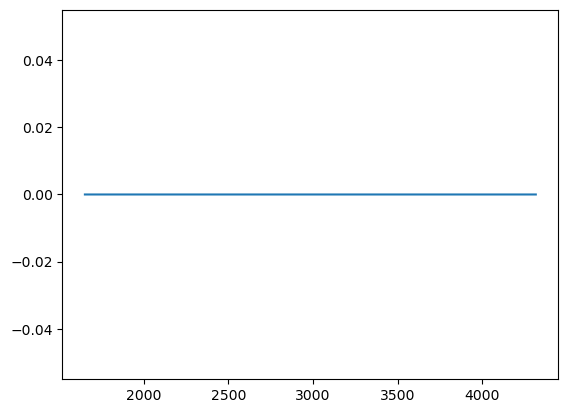

Closing remaining open files:/tmp/nilmtk-zbuuzryk.h5...done


In [105]:
tb = pd.read_pickle("../../Energy_graph/data/tracebase/devices_data.pkl")
device = "washing machine"
from random import randint
i = randint(0, len(tb[device])-1)
offset = randint(0, len(tb[device][i])-2688)
x = tb[device][i][offset:offset+2668].copy()
x[x<5] = 0
plt.plot(x)
x = x.values.reshape(1, -1)
# print(x.values.reshape(1, -1)[0])
model_predictions = []
for m in models:
    y_pred = m.predict(x)
    model_predictions.append(y_pred)
    
y_pred_avg = np.mean(model_predictions, axis=0)
y_pred_tf = np.where(y_pred_avg > 0.3, 1, 0)
print(y_pred_tf)
for i in range(len(labels)):
    if y_pred_tf[0][i] == 1:
        print(labels[i])
    
plt.show()

In [9]:
import pandas as pd
import re
import os

def preprocess_string(string : str) -> str:
    string = string.lower().strip()
    string = re.sub(' +', ' ', string)
    string = string.replace("_", " ")
    string = string.replace("-", " ")
    string = string.replace("&", " ")
    string = string.split("(")[0]
    string = string.split("#")[0]

    string = string.strip()

    # handle known synoynms
    synonyms = {
        "refrigerator": "fridge",
        "vaccumcleaner": "vacuum cleaner",
        "breadmaker": "bread maker",
      
        
    }
    if "freezer" in string:
        string = "fridge"

    if string in synonyms:
        string = synonyms[string]

    if 'hi fi' in string:
        string = "audio system"

    if "router" in string:
        string = "router"

    if "treadmill" in string:
        string = "running machine"
        

    if "laptop" in string:
        string = "laptop"
    
    if "server" in string:
        string = "server"

    if "monitor" in string and not "baby" in string:
        string = "monitor"
    # special cases
    if "computer" in string and "charger" not in string:
        string = "pc"

    if "tv" in string:
        string = "television"

    if "television" in string:
        string = "television"

    if "macbook" in string:
        string = "laptop"
        
    if "car charger" == string:
        string = "ev"
    
    if "toast" in string:
        string = "toaster"
    
    if "modem" in string:
        string = "router"

    # we treat all audio devices as speakers so subwoofer is also a speaker
    if "subwoofer" in string:
        string = "speaker"

    if "speaker" in string:
        string = "speaker"

    if "iron" in string and "soldering" not in string:
        string = "iron"

    
    if "coffeemachine" in string:
        string = "coffee machine"
    if "coffee maker" in string:
        string = "coffee machine"

    if "dishwasher" in string:
        string = "dish washer"
    if "air conditioner" in string:
        string = "ac"

    if "air conditioning" in string:
        string = "ac"
    
    string = re.sub(' +', ' ', string)
    string = re.sub(r'\d+', '', string)
    return string.strip()



In [23]:
folder = ""
path_to_base = "../../Energy_graph/"
path = path_to_base + "/data/processed_watts/"+folder
labels_path = path_to_base + "/data/labels_new.pkl"
save_path = path_to_base + "/data/training_data/processed/"+folder

models = []
labels = pd.read_pickle(labels_path)

for f in os.listdir("./models/bfloat_normalized/"):
        if "last" in f:
            model = tf.keras.models.load_model("./models/bfloat_normalized/"+f, custom_objects={'F1Score': NUK.F1Score, "WeightedF1": NUK.WeightedF1Score(class_weighs_pre)})
            models.append(model)


X= normalize(X)
print(len(X.shape))

if len(X.shape) !=2 or X.shape[1] != 2688:
    print("wrong shape", X.shape)

model_predictions = []
for m in models:
        y_pred = m.predict(X)
        model_predictions.append(y_pred)



y_pred_avg = np.mean(model_predictions, axis=0)
y_pred_tf = np.where(y_pred_avg > 0.3, 1, 0)

y_pred_num_devices = np.sum(y_pred_tf, axis=1)
y_real_num_devices = np.sum(y, axis=1)

# print("average number of devices misspredcited: ", np.mean(y_pred_num_devices - y_real_num_devices)	)
path = "../../Energy_graph/data/results/test"
# check if directory exsits
if not os.path.exists(f"{path}"):
    os.makedirs(f"{path}")


res = metrics.classification_report(y, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
df = pd.DataFrame(res).T

df.to_csv(f"{path}/ensemble.csv")

print("Ensemble: ", res["weighted avg"]["f1-score"], res["weighted avg"]["precision"], res["weighted avg"]["recall"])
for i, p in enumerate(model_predictions):
    y_pred_tf = np.where(p > 0.3, 1, 0)
    single = metrics.classification_report(y, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)
    df = pd.DataFrame(single).T
    df.to_csv(f"{path}/single_{i}.csv")
    print(f"Single_{i}: ", single["weighted avg"]["f1-score"], single["weighted avg"]["precision"], single["weighted avg"]["recall"])

# # barplot y_pred_tf
# plt.figure(figsize=(20,10))
# plt.bar(labels, y_pred_tf.sum(axis=0))
# # plt.title(h + real_str + "f1: "+ str(res["weighted avg"]["f1-score"]) + "precision: "+ str(res["weighted avg"]["precision"]) + "recall: "+ str(res["weighted avg"]["recall"]))
# plt.title(" f1: "+ str(res["weighted avg"]["f1-score"])[:5] + " average number of devices misspredcited: " + str(np.mean(y_pred_num_devices - y_real_num_devices))[:5]	)

# # Get current axis
# ax = plt.gca()

# # Loop through label list and set the color to red for highlighted labels
# for label in ax.get_xticklabels():
#     if label.get_text() in curr_devices:
#         label.set_color('red')

# # Rotate all labels
# plt.xticks(rotation=90)
# plt.savefig(f"./plots/real_ideal/test_barplot.svg", format="svg")
# plt.close()
pd.DataFrame(res).T

2
3125/3125 [==============================] - 80s 25ms/step
Ensemble:  0.05498499229837306 0.11609638926021774 0.08664122375031907
Single_0:  0.05454351664771011 0.11638884656663885 0.07865223102832133
Single_1:  0.049593168530481076 0.1060938875113711 0.07316602436792201
Single_2:  0.05078556918896599 0.11523552292479254 0.07438628821885059
Single_3:  0.05283913267450157 0.11186682159508442 0.0734636193274852
Single_4:  0.052719927047926246 0.1114511583901698 0.07810809296418277


,precision,recall,f1-score,support
microwave,0.161126,0.593877,0.253480,12772.0
air exchanger,0.145669,0.014225,0.025919,13005.0
combination microwave,0.165685,0.065732,0.094123,12840.0
router,0.133913,0.006010,0.011503,12813.0
water purifier,0.856909,0.121826,0.213324,12879.0
...,...,...,...,...
stove,0.000000,0.000000,0.000000,12640.0
micro avg,0.165996,0.086641,0.113856,803105.0
macro avg,0.114437,0.085215,0.054144,803105.0
weighted avg,0.116096,0.086641,0.054985,803105.0


In [8]:
folder = ""
path_to_base = "../../Energy_graph/"
path = path_to_base + "/data/processed_watts/"+folder
labels_path = path_to_base + "/data/labels_new.pkl"
save_path = path_to_base + "/data/training_data/processed/"+folder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_test= normalize(X_test)


In [39]:
from itertools import combinations, permutations, combinations_with_replacement

def comb_ix(nm_devices : int):
    """Returns all possible combinations of indexes for a given number of devices"""
    models = [0,1,2,3,4]

   
    return list(combinations(models, nm_devices))
    


ixs = comb_ix(4)
for i in ixs:
    for j in i:
        print(j)
    break

0
1
2
3


In [14]:
import os
models = []
labels = pd.read_pickle(labels_path)

for f in os.listdir("./models/bfloat_normalized/"):
        if "last" in f:
            model = tf.keras.models.load_model("./models/bfloat_normalized/"+f, custom_objects={'F1Score': NUK.F1Score, "WeightedF1": NUK.WeightedF1Score(class_weighs_pre)})
            models.append(model)



# print(len(X.shape))

# if len(X.shape) !=2 or X.shape[1] != 2688:
#     print("wrong shape", X.shape)

model_predictions = []
for m in models:
        y_pred = m.predict(X_test)
        model_predictions.append(y_pred)



625/625 [==============================] - 16s 25ms/step


In [45]:

for i in range(1, 6):
    ixs = comb_ix(i)
    num_models = []
    for c in ixs:
        model_preds = []
        for ix in c:
            model_preds.append(model_predictions[ix])

        y_pred_avg = np.mean(model_preds, axis=0)
        y_pred_tf = np.where(y_pred_avg > 0.3, 1, 0)
        res = pd.DataFrame(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0, output_dict=True)).T
        num_models.append(res)
    for j in range(len(ixs)):
        if j == 0:
            df = num_models[j]
        else:
            df = df + num_models[j]

    df = df / len(ixs)
    if not os.path.exists(f"./results/ensemble_size/"):
        os.makedirs(f"./results/ensemble_size/")
    df.to_csv(f"./results/ensemble_size/ensemble_{i}.csv")        





In [50]:
df = pd.read_csv("./results/ensemble_size/ensemble_1.csv")
df.iloc[-1]["f1-score"]

0.5261098399662478

In [79]:
data = {}
for i,f in enumerate(os.listdir("./results/ensemble_size/")):
    if f.endswith(".csv"):
        df = pd.read_csv("./results/ensemble_size/"+f)
        data[f.split(".")[0][-1]]= df.iloc[-1]["f1-score"]
res = []

for i in range(1, 6):
    res.append(data[str(i)])
res

[0.5261098399662478,
 0.544831932262206,
 0.5629701308673057,
 0.5913152811030575,
 0.5980600405358989]

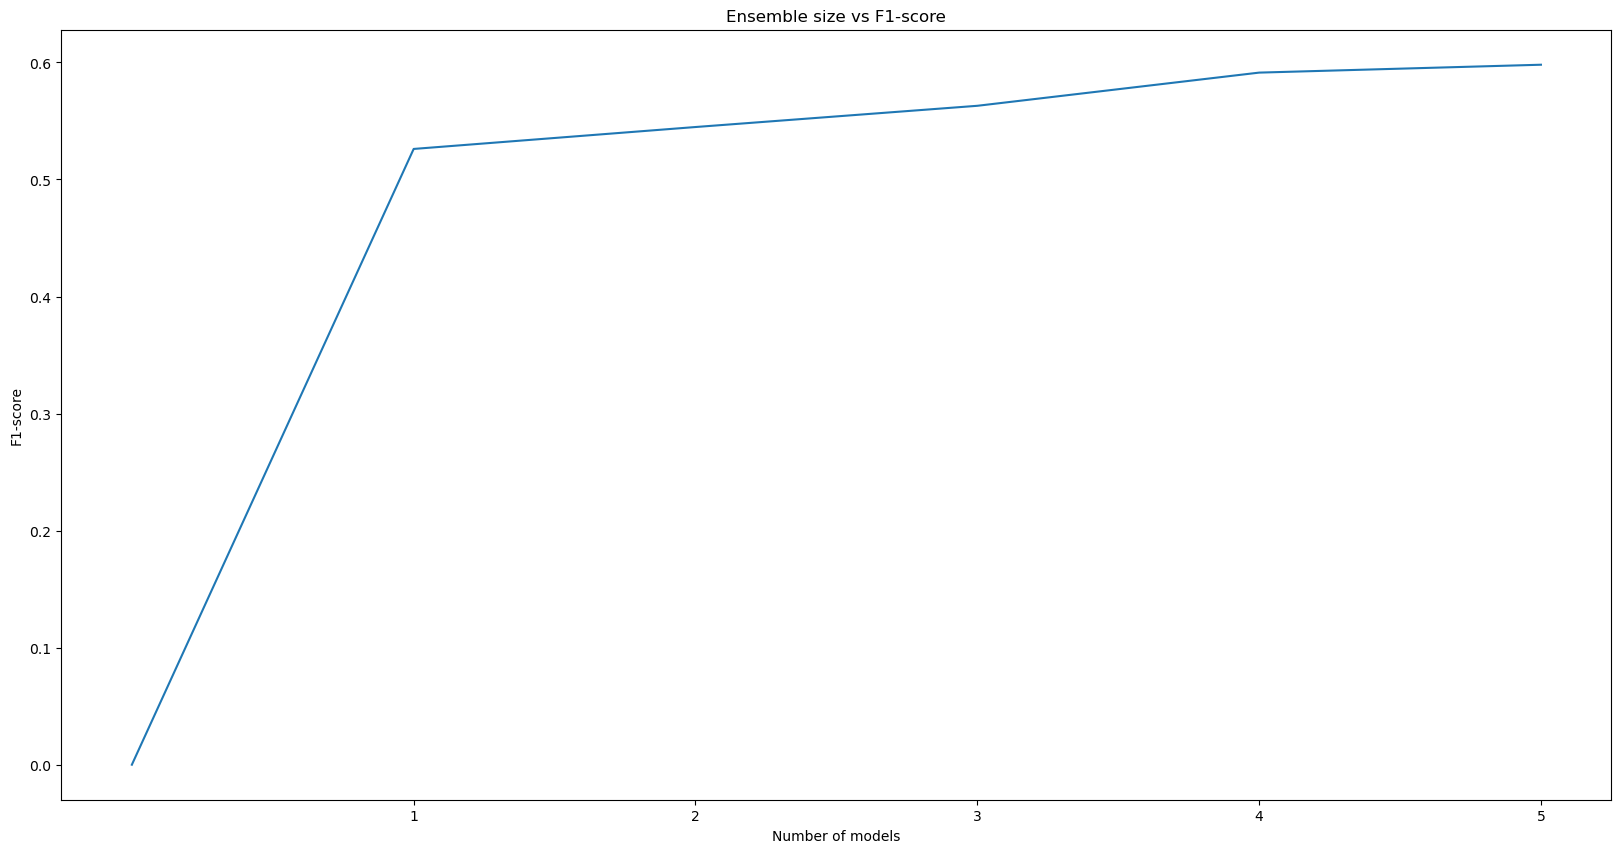

In [76]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(res)
plt.xticks([1,2,3,4,5])
plt.xlabel("Number of models")
plt.ylabel("F1-score")
plt.title("Ensemble size vs F1-score")
plt.show()

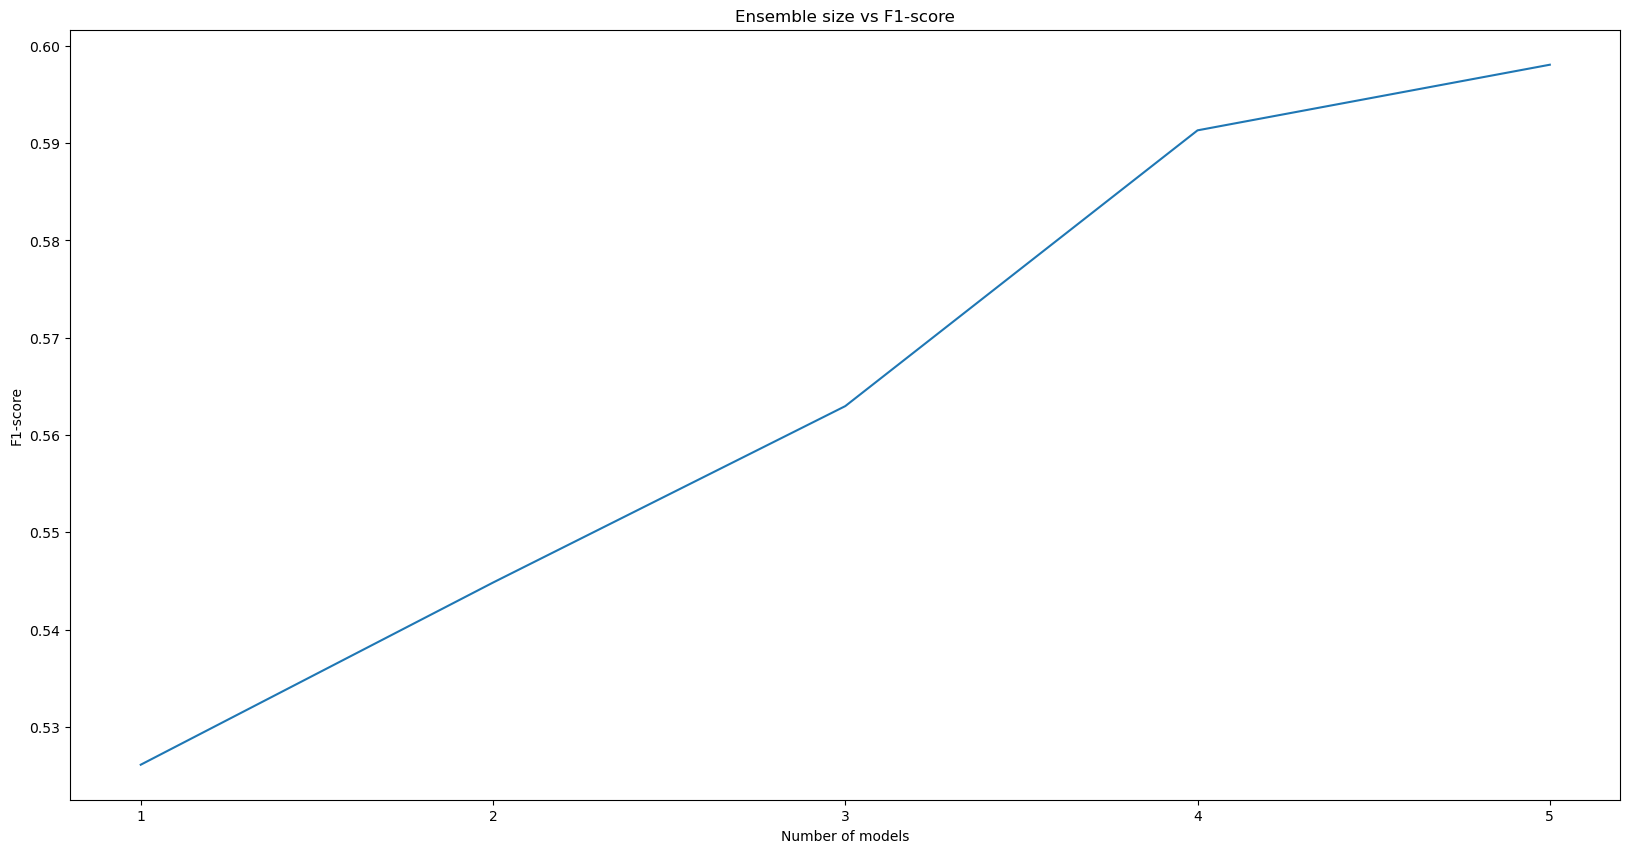

Closing remaining open files:/tmp/nilmtk-0ofq2mdx.h5...done


In [80]:
from matplotlib import pyplot as plt

# Example data - replace this with your actual 'res' data


plt.figure(figsize=(20,10))
plt.plot([1, 2, 3, 4, 5], res)  # Explicitly setting x-values from 1 to 5
plt.xticks([1, 2, 3, 4, 5])  # Setting x-ticks
plt.xlabel("Number of models")
plt.ylabel("F1-score")
plt.title("Ensemble size vs F1-score")
plt.show()


In [45]:
from random import randint
data = pd.read_pickle("../../Energy_graph/data/training_data/synthetic/X_Y_wsize2688_numW_50001_upper32_gap3600_numD64_ideal.pkl")

X = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])

X = normalize(X)


15

In [46]:
X.shape, len(X)
y

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1/1 [==============================] - 0s 18ms/step


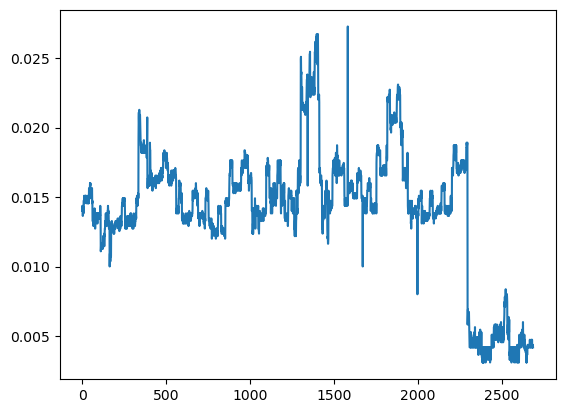


real:   dryer
pred:   pc television


In [52]:

ix = randint(0, len(X)-1)
# x = X[ix]

predictions = []
for m in models:
    y_pred = m.predict(X[ix].reshape(1, -1))
    predictions.append(y_pred)

y_pred_avg = np.mean(predictions, axis=0)
y_pred_tf = np.where(y_pred_avg > 0.3, 1, 0)

labels = pd.read_pickle(labels_path)
pred = ""
real = ""
for i in range(len(labels)):
    if y[ix][i] == 1:
        real+=" " + str(labels[i])
    if y_pred_tf[0][i] == 1:
        pred+= " " + str(labels[i])
plt.plot(X[ix])
plt.show()

print()
print("real: ", real)
print("pred: ", pred)